<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/playwright_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install playwright
!playwright install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 25.8 MB/s eta 0:00:00
146.4 Mb [] 0% 0.0s146.4 Mb [] 0% 11.6s146.4 Mb [] 0% 6.7s146.4 Mb [] 1% 3.8s146.4 Mb [] 2% 2.9s146.4 Mb [] 3% 2.6s146.4 Mb [] 3% 2.4s146.4 Mb [] 4% 2.3s146.4 Mb [] 5% 2.1s146.4 Mb [] 6% 2.0s146.4 Mb [] 7% 2.0s146.4 Mb [] 8% 1.9s146.4 Mb [] 9% 1.8s146.4 Mb [] 11% 1.6s146.4 Mb [] 13% 1.5s146.4 Mb [] 14% 1.5s146.4 Mb [] 15% 1.4s146.4 Mb [] 15% 1.5s146.4 Mb [] 16% 1.5s146.4 Mb [] 18% 1.4s146.4 Mb [] 19% 1.4s146.4 Mb [] 21% 1.3s146.4 Mb [] 22% 1.3s146.4 Mb [] 24% 1.2s146.4 Mb [] 25% 1.2s146.4 Mb [] 26% 1.2s146.4 Mb [] 28% 1.1s146.4 Mb [] 29% 1.1s146.4 Mb [] 30% 1.1s146.4 Mb [] 32% 1.0s146.4 Mb [] 33% 1.0s146.4 Mb [] 34% 1.0s146.4 Mb [] 36% 1.0s146.4 Mb [] 37% 1.0s146.4 Mb [] 38% 1.0s146.4 Mb [] 40% 0.9s146.4 Mb [] 41% 0.9s146.4 Mb [] 42% 0.9s146.4 Mb [] 44% 0.9s146.4 Mb [] 45% 0.9s146.4 Mb [] 46% 0.8s146.4 Mb [] 47% 0.8s146.4 Mb [] 49% 0.8s146.4 Mb [] 50% 0.7s146.4 Mb [] 52% 0.7s146.4 Mb [] 53% 0.7s146.4 Mb []

In [3]:
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import random
import os
import numpy as np
from playwright.async_api import async_playwright

In [4]:
def match_span_class(tag):
    parent_span = tag.find_parent('span')
    if parent_span is not None:
        span_classes = parent_span.get('class', [])
        return any(cls.startswith('SummaryItemResponsive') for cls in span_classes)
    return False

In [5]:
faces = ['smiling-person', 'anger-person', 'disgust-person', 'fear-person', 'surprise-person' ]

In [13]:
pages = [i for i in range(1,11)]

In [16]:
pages

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [36]:
# https://www.istockphoto.com/pl/search/2/image?page=4&phrase=smiling%20person
images = []
for face in faces:
  modified_face = face.replace('-', '%20')
  for page in range(3,10):
    async def run():
      async with async_playwright() as p:
        browser = await p.chromium.launch()
        print('BROWSER')
        print(browser)
        page = await browser.new_page()
        print("PAGE")
        print(page)
        await page.goto(f'https://www.istockphoto.com/pl/search/2/image?phrase=smiling%20person')
        # Get the page content
        content = await page.content()
        print("CONTENT")
        print(content)
        await browser.close()
        # Use Beautiful Soup to parse the HTML
        soup = BeautifulSoup(content, 'html.parser')
        # Find all image tags and add their src attributes to the image_sources list
        all_images = soup.find_all('img')
        images_in_span = soup.find_all(lambda tag: tag.name == 'img' and match_span_class(tag))
        interesting_images = [img for img in all_images if img not in images_in_span]
        for img in interesting_images:
          src = img.get('src')
          images.append(src)
        print(images)
    images = []
    await run()

BROWSER
<Browser type=<BrowserType name=chromium executable_path=/root/.cache/ms-playwright/chromium-1067/chrome-linux/chrome> version=115.0.5790.24>
PAGE
<Page url='about:blank'>
CONTENT
<!DOCTYPE html><html class="pl no-js  " lang="pl-PL" prefix="og: http://ogp.me/ns#"><head><script async="" src="https://www.googletagmanager.com/gtm.js?id=GTM-WF3KCX5"></script><script>window.renderStart = new Date().getTime();
window.currentSite = {
  domainSuffix: "com",
  nickname: "istock",
  isGetty: false,
  isiStock: true,
  pathPrefix: "pl",
  tld: "",
}
window.notificationsContext = '';
window.currentApplication = "search";
window.pipelineId = "1780649";
window.requireCookieConsent = false
window.environment = {
  isProduction: true
}
window.pipelineId = "1780649"</script><link rel="preconnect" href="//spectrum.gettyimages.com"><link rel="preconnect" href="//media.istockphoto.com"><link rel="dns-prefetch" href="//spectrum.gettyimages.com"><link rel="dns-prefetch" href="//media.istockphoto.com

CancelledError: ignored

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
def get_image(photo_url, path, file_name, face):
  image_response = requests.get(photo_url)
  image_content = image_response.content
  img = Image.open(BytesIO(image_content))
  if img.mode == 'RGB':
    os.makedirs(f'{path}/{face}', exist_ok=True)
    img.save(f'{path}/{face}/{file_name}', 'png')

In [17]:
train_path = 'drive/MyDrive/faces/data/train'

In [18]:
def get_photos(source, path, face):
  for image in source:
    http = image.find('https://')
    if http != -1:
      file_name = image.split('/')[-1]
      get_image(image, train_path, file_name, face)

In [19]:
faces = ['smiling-person', 'anger-person', 'disgust-person', 'fear-person', 'surprise-person' ]

In [ ]:
# get_photos(image_sources, train_path, faces[0])

TypeError: ignored

In [ ]:
# pages = 1
# for face in faces:
#   modified_face = face.replace('-', '%20')
#   print(modified_face)
#   for page in range(1, pages +1):
#     get_photos(face, page, train_path)

In [36]:
# image_sources = []
# for face in faces:
#   modified_face = face.replace('-', '%20')
#   get_page(3, modified_face, image_sources)
#   await run()
#   print(face)
#   print(image_sources)
#   image_sources = []


In [45]:
image_sources = []
get_page(image_sources)
await run()
image_sources

['/search/assets/static/color_mood_all-426fbeb2abd7da282b67.jpg',
 'https://media.istockphoto.com/id/1289220545/pl/zdj%C4%99cie/pi%C4%99kna-kobieta-u%C5%9Bmiechni%C4%99ta-ze-skrzy%C5%BCowanymi-ramionami.jpg?s=612x612&w=0&k=20&c=QjMDPmOjkYujFbpHaVLEdWzXk_-WPfLixkoxDqkmDkI=',
 'https://media.istockphoto.com/id/969233490/pl/zdj%C4%99cie/m%C5%82oda-afryka%C5%84ska-kobieta-u%C5%9Bmiechaj%C4%85ca-si%C4%99-o-zachodzie-s%C5%82o%C5%84ca.jpg?s=612x612&w=0&k=20&c=Q5_ob_pqUrFU0dzcMa3ifSz3aeXx0Vb6R6xcj-X7-FY=',
 'https://media.istockphoto.com/id/1369508766/pl/zdj%C4%99cie/pi%C4%99kna-odnosz%C4%85ca-sukcesy-latynoska-kobieta-u%C5%9Bmiechni%C4%99ta.jpg?s=612x612&w=0&k=20&c=mzhHRgTeEBg0LINMqoXNjTRFgkeliU02HDWPx_Sd0zk=',
 'https://media.istockphoto.com/id/1297159365/pl/zdj%C4%99cie/portret-m%C5%82odej-u%C5%9Bmiechni%C4%99tej-kobiety-twarz-cz%C4%99%C5%9Bciowo-pokryte-lataj%C4%85ce-w%C5%82osy-w-wietrzny.jpg?s=612x612&w=0&k=20&c=DQPRK4zjudv2MXslFwIEJUok_cV1TRpeKSqHjjRBy8E=',
 'https://media.istockphoto.co

In [ ]:
# import os
# import requests
# from PIL import Image
# import numpy as np

# # Create a directory to store the images
# os.makedirs('images', exist_ok=True)

# # Download the images
# for i, url in enumerate(image_sources):
#     response = requests.get(url, stream=True)
#     with open('images/img{}.jpg'.format(i), 'wb') as out_file:
#         out_file.write(response.content)
#     del response

# # Read the images into a list
# images = [Image.open('images/img{}.jpg'.format(i)) for i in range(len(image_sources))]

# # Set a common size for all images
# common_size = (200, 200)

# # Resize all images to the common size
# resized_images = [img.resize(common_size) for img in images]

# # Calculate the number of rows and columns for the grid
# grid_size = math.ceil(math.sqrt(len(resized_images)))
# while len(resized_images) < grid_size**2:
#     # If the number of images is not a perfect square, append empty images to fill the grid
#     resized_images.append(Image.new('RGB', common_size))

# # Create the rows for the grid
# rows = [np.hstack(resized_images[i:i+grid_size]) for i in range(0, len(resized_images), grid_size)]

# # Stack the rows to create the final grid
# grid = np.vstack(rows)

# # Convert the NumPy array back to an Image object and save it
# collage = Image.fromarray(grid)
# collage


MissingSchema: ignored

In [ ]:
# !pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.9 MB/s eta 0:00:00


15/15 [==============================] - 0s 23ms/step


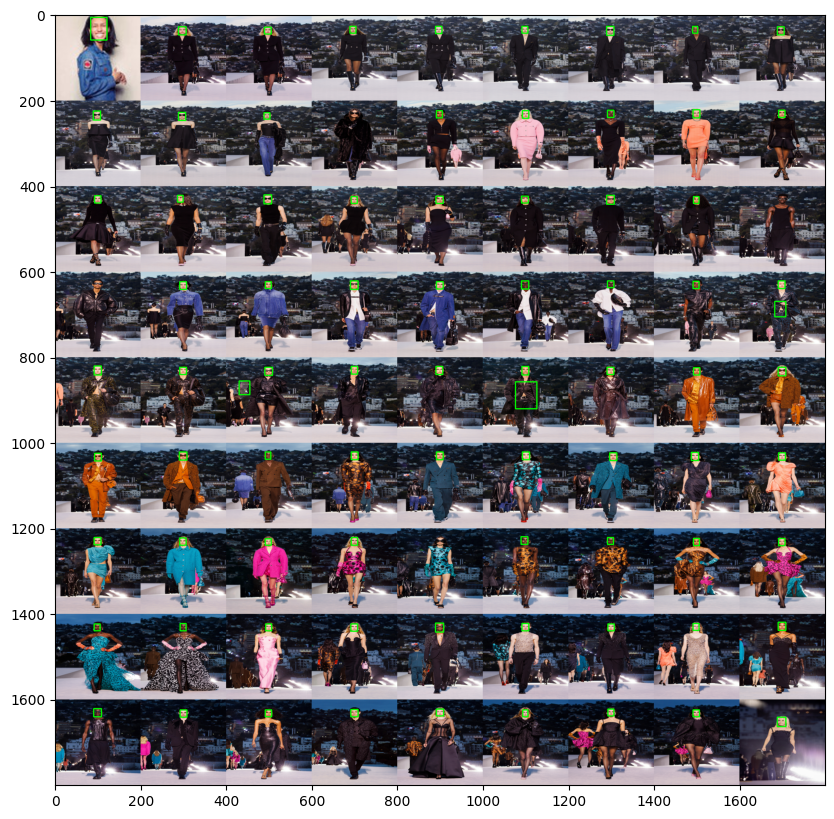

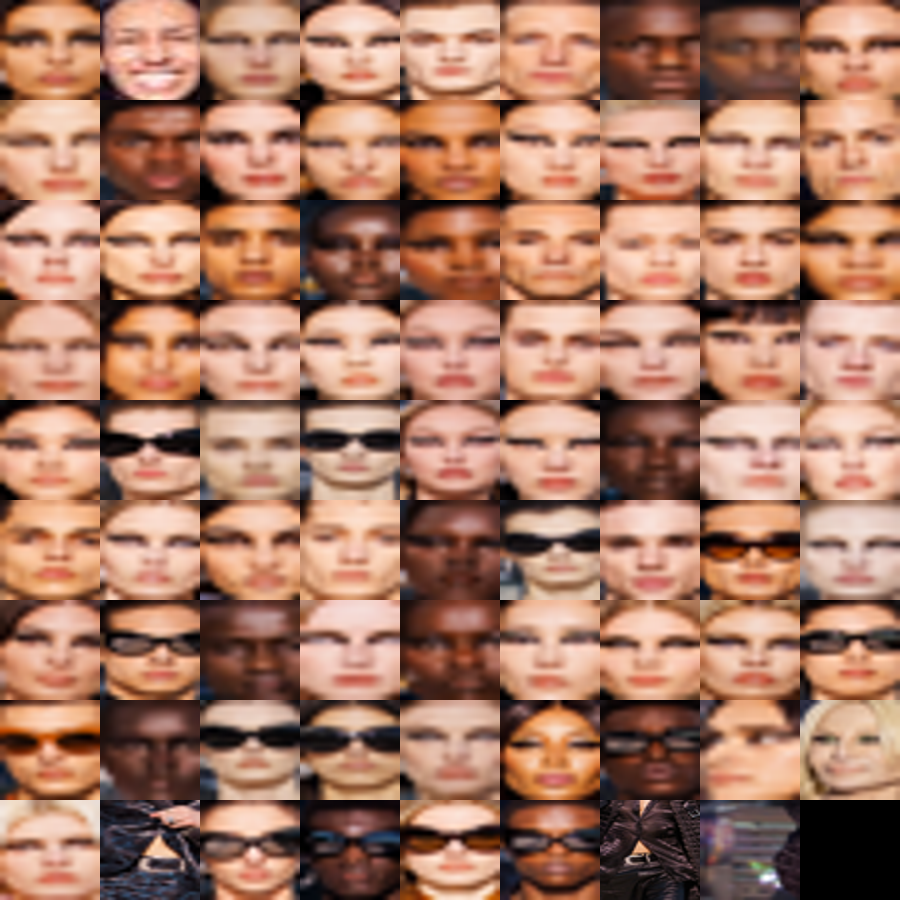

In [ ]:
# from mtcnn import MTCNN

# # Create the detector
# detector = MTCNN()

# # Convert PIL image to numpy array
# numpy_image = np.array(collage)

# # Perform face detection
# faces = detector.detect_faces(numpy_image)

# # List to hold face images
# face_images = []

# # Draw a rectangle around the faces and extract them
# for face in faces:
#     x, y, width, height = face['box']
#     cv2.rectangle(numpy_image, (x, y), (x+width, y+height), (0, 255, 0), 2)

#     # Extract face
#     face_img = collage.crop((x, y, x+width, y+height))
#     face_images.append(face_img)

# # Show the image
# plt.figure(figsize=(10, 10))  # Adjust figure size here
# plt.imshow(numpy_image)
# plt.show()

# # Resize all faces to a common size
# common_size = (100, 100)  # Adjust this value according to your preference
# face_images_resized = [img.resize(common_size) for img in face_images]

# # Calculate the grid size
# grid_size = math.ceil(math.sqrt(len(face_images_resized)))

# # Create the rows for the grid
# rows = []
# for i in range(0, len(face_images_resized), grid_size):
#     row = face_images_resized[i:i+grid_size]
#     row_widths = [img.width for img in row]
#     max_width = max(row_widths)
#     row_padded = [np.array(img.resize((max_width, img.height))) for img in row]
#     row_stacked = np.hstack(row_padded)
#     rows.append(row_stacked)

# # Pad rows with background color to match the maximum width
# max_width = max([row.shape[1] for row in rows])
# rows_padded = [np.pad(row, ((0, 0), (0, max_width - row.shape[1]), (0, 0)), mode='constant', constant_values=0) for row in rows]

# # Stack the rows to create the final grid
# grid = np.vstack(rows_padded)

# # Convert the NumPy array back to an Image object and display it
# face_collage = Image.fromarray(grid)
# face_collage.show()
